In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
import statsmodels.api as sm
from statsmodels.tsa.vector_ar.var_model import VAR
import os

In [3]:
assert os.path.isfile('./equity.pkl'), 'Data file Missing!'

In [4]:
file = os.path.basename('./equity.pkl')
df = pd.read_pickle(file)

In [6]:
# Compute returns
df.index = pd.to_datetime(df.index)
df['P Logged Returns'] = (np.log(df['P']) - np.log(df['P'].shift())).dropna().mul(100)
df['D Logged Returns'] = (np.log(df['D']) - np.log(df['D'].shift())).dropna().mul(100)

/var/folders/_8/50mbqfv150q2ctjn78cvlxbr0000gn/T/ipykernel_4542/2358669398.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.index = pd.to_datetime(df.index)


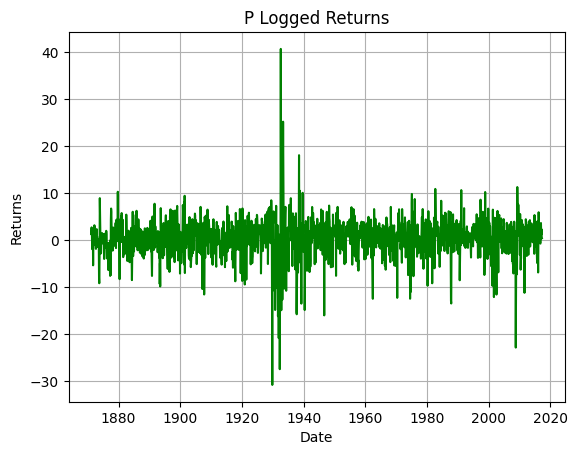

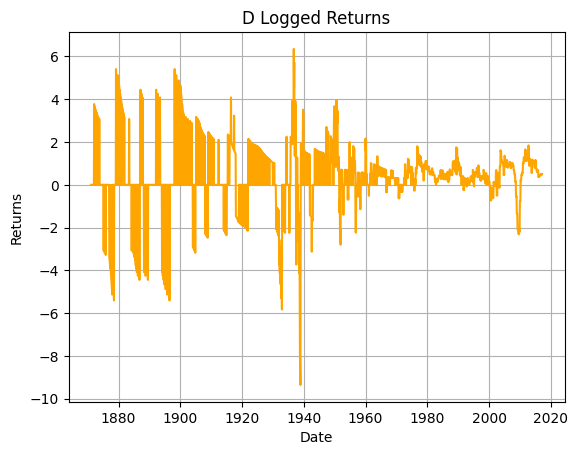

In [9]:
# Plot both returns

plt.plot(df['P Logged Returns'],color='green');plt.title('P Logged Returns');plt.ylabel('Returns');plt.xlabel('Date');plt.grid();plt.show()
plt.plot(df['D Logged Returns'],color='orange');plt.title('D Logged Returns');plt.ylabel('Returns');plt.xlabel('Date');plt.grid();plt.show()


## Time Series Patterns
The time series graphs show what looks to be like a stationary process however the variability of the two graphs do seem to change over time. The log returns for both stock prices and dividends hover oscilate around 0 with no drift. There was a period of high volatility for both returns and dividends around 1920s to 1940s which contained the events of the Great Depression and WW2. Interestingly, the logged returns for dividends showed high volatility even preceeding 1940 all the way back to the start of hte dataset in the late 1800s. This indicates that dividend payments were highly volatile in the past, perhaps due to the irregularity of payments or lack of consitent dividend price modelling. There is a slight decrease in dividend returns and stock returns in 2008 but nowhere near as volatile as the 1940s.

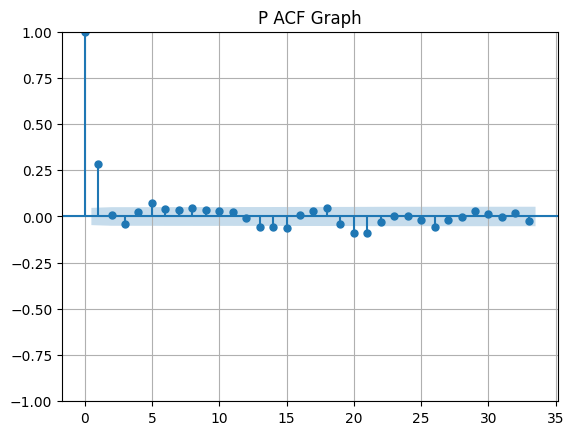

In [11]:
# Plot equity return ACF
plot_acf(df['P Logged Returns'].dropna());plt.title('P ACF Graph');plt.grid();plt.show()


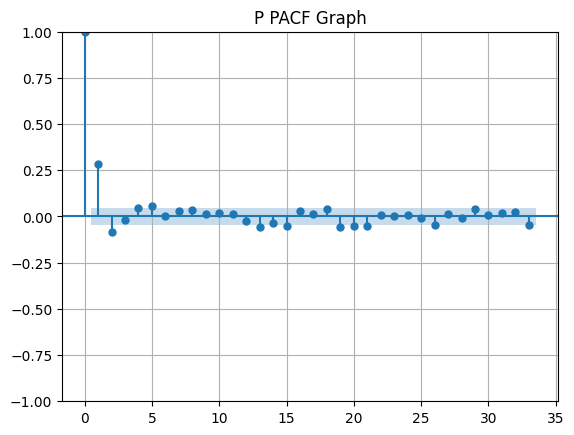

In [12]:
# Plot equity return PACF
plot_pacf(df['P Logged Returns'].dropna());plt.title('P PACF Graph');plt.grid();plt.show()

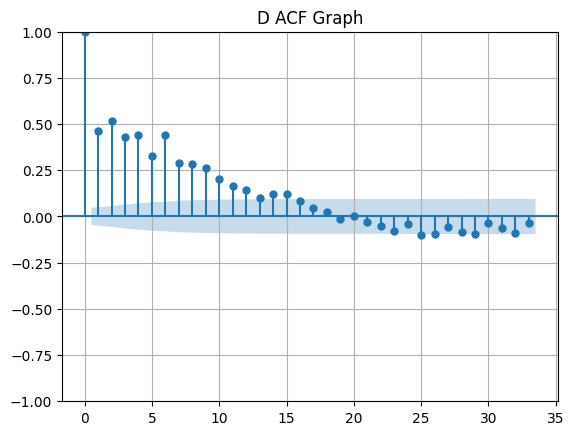

In [13]:
# Plot dividend return ACF
plot_acf(df['D Logged Returns'].dropna());plt.title('D ACF Graph');plt.grid();plt.show()

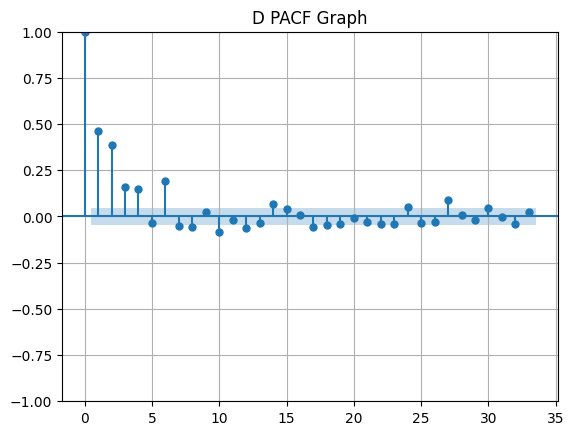

In [14]:
# Plot dividend return PACF
plot_pacf(df['D Logged Returns'].dropna());plt.title('D PACF Graph');plt.grid();plt.show()

## ACF & PACF Plots 
The ACF Plots represent the autocorrelations at each lagged interval. The Logged Price PACF only has one signficant autocorrelated lag which is at lag 1. The coefficient there is at around .30 meaning that the prior month value will have some influence on the current month value. The ACF for the dividend returns show signficant autocorrelations from lags 1 to 12 and even including 14 and 15. This shows that prior dividend returns are highly correlated to future dividend returns. The number of signficance lags will help determine the order of MA. 

The PACF Plots displays the partial autocorrelations which is a measure of the direct effects of lagged values with current values. For instance, for some time t-1, t-2, t-3 , the partial autocorrelation of lag 3 measure the direct dependence from t to t-3 and not accounting for the indirect effects through lag t-1, t-2 etc... Thus they can also be estimated through OLS regressions because the coefficients (independent variables) will represent only the direct effects after controlling for indirect ones.
The signficance of the lags in the PACF plots help determine the order of the AR. The PACF for Price is signficant for lags 1,2 and potentially 5. While for dividend returns, the PACF was signficant for lag 1-4 and 6 and even at later lags too.

In [74]:
#Using OLS of Lagged Dependent Variables
y = df['P Logged Returns'].dropna()
x = df['P Logged Returns'].shift(1)
x1 = df['P Logged Returns'].shift(2)
x2 = df['P Logged Returns'].shift(3)
x3 = df['P Logged Returns'].shift(4)
x4 = df['P Logged Returns'].shift(5)
x5 = df['P Logged Returns'].shift(6)
a = pd.concat([y,x,x1,x2,x3,x4,x5],axis=1).dropna()
a.columns = ['P', 'P Lag 1', 'P Lag 2', 'P Lag 3','P Lag 4', 'P Lag 5', 'P Lag 6']
y = a.iloc[:,0]
x = a.iloc[:,1:]
x = sm.add_constant(x)

sm.OLS(y,x).fit().summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      P   R-squared:                       0.092
Model:                            OLS   Adj. R-squared:                  0.089
Method:                 Least Squares   F-statistic:                     29.41
Date:                Tue, 25 Jun 2024   Prob (F-statistic):           1.05e-33
Time:                        17:48:33   Log-Likelihood:                -4850.7
No. Observations:                1749   AIC:                             9715.
Df Residuals:                    1742   BIC:                             9754.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2519      0.094      2.673      0.008       0.067       0.437
P Lag 1        0.3033      0.024     12.661      0.000       0.256       0.350
P Lag 2       -0.0698      0.025     -2.793      0.005      -0.119      -0.021
P Lag 3       -0.0307      0.025     -1.224      0.221      -0.080       0.018
P Lag 4        0.0289      0.025      1.152      0.249      -0.020       0.078
P Lag 5        0.0559      0.025      2.236      0.025       0.007       0.105
P Lag 6        0.0039      0.024      0.164      0.870      -0.043       0.051
==============================================================================
Omnibus:                      361.139   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8618.919
Skew:                          -0.329   Prob(JB):                         0.00
Kurtosis:                      13.855   Cond. No.                         5.14
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## OLS AR(6)
The AR 6 Model estimated using OLS where the coefficeints measures only the direct dependence between the variable and its lag shows that lag 1,2 and 5 are signficant. This aligns exactly with our PACF graph for price as the only points that exceeded our confidence interval were lags 1,2,5. Lag 1 had a coefficient of .3033 which can be interpreted as a 1% increase in logged returns from the preceeding month will increase next month returns by .3033%. Lag 5 also positively affects the future returns but to a much lesser extent at .0559. The 2nd lag has a negative effect or inverse effect on the future price returns.

In [75]:
#Using AutoReg
model = AutoReg(df['P Logged Returns'].dropna(),lags = 6).fit()
model.summary()

/Users/jasonting/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:       P Logged Returns   No. Observations:                 1755
Model:                     AutoReg(6)   Log Likelihood               -4850.696
Method:               Conditional MLE   S.D. of innovations              3.875
Date:                Tue, 25 Jun 2024   AIC                           9717.393
Time:                        17:48:37   BIC                           9761.127
Sample:                    08-01-1871   HQIC                          9733.560
                         - 04-01-2017                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.2519      0.094      2.678      0.007       0.068       0.436
P Logged Returns.L1     0.3033      0.024     12.686      0.000       0.256       0.350
P Logged Returns.L2    -0.0698      0.025     -2.799      0.005      -0.119      -0.021
P Logged Returns.L3    -0.0307      0.025     -1.227      0.220      -0.080       0.018
P Logged Returns.L4     0.0289      0.025      1.155      0.248      -0.020       0.078
P Logged Returns.L5     0.0559      0.025      2.241      0.025       0.007       0.105
P Logged Returns.L6     0.0039      0.024      0.164      0.870      -0.043       0.051
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.5906           -0.0000j            1.5906           -0.0000
AR.2            0.6131           -1.4715j            1.5941           -0.1872
AR.3            0.6131           +1.4715j            1.5941            0.1872
AR.4           -1.6932           -1.3197j            2.1468           -0.3946
AR.5           -1.6932           +1.3197j            2.1468            0.3946
AR.6          -13.6952           -0.0000j           13.6952           -0.5000
-----------------------------------------------------------------------------
"""

In [78]:
model = sm.tsa.AutoReg(df['P Logged Returns'].dropna(), lags= 3).fit()
display(model.summary())
residuals = model.resid

/Users/jasonting/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:       P Logged Returns   No. Observations:                 1755
Model:                     AutoReg(3)   Log Likelihood               -4862.514
Method:               Conditional MLE   S.D. of innovations              3.882
Date:                Tue, 25 Jun 2024   AIC                           9735.028
Time:                        17:49:04   BIC                           9762.370
Sample:                    05-01-1871   HQIC                          9745.135
                         - 04-01-2017                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.2801      0.094      2.995      0.003       0.097       0.463
P Logged Returns.L1     0.3053      0.024     12.784      0.000       0.259       0.352
P Logged Returns.L2    -0.0753      0.025     -3.024      0.002      -0.124      -0.027
P Logged Returns.L3    -0.0210      0.024     -0.879      0.380      -0.068       0.026
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.5927           -2.1204j            2.6519           -0.1475
AR.2            1.5927           +2.1204j            2.6519            0.1475
AR.3           -6.7747           -0.0000j            6.7747           -0.5000
-----------------------------------------------------------------------------
"""

In [79]:
# MA(3)

#Independent Variables
x1 = residuals.shift(1)
x2 = residuals.shift(2)
x3 = residuals.shift(3)

df_resid = pd.concat([residuals,x1,x2,x3],axis=1) #Put them all in one dataframe to be able to call dropna once and ensure all columns have the same length 
df_resid.columns = ['Residauls', 'Resid Lag 1', 'Resid Lag 2', 'Resid Lag 3'] # Rename columns 

#Ensures every column is aligned properly 
df_resid.dropna(inplace=True) 

xvars = df_resid.iloc[:,1:] #Splice to Get Array of X-Variables
yvars = df_resid.iloc[:,0]  
xvars = sm.add_constant(xvars) #Add Constant

sm.OLS(yvars,xvars).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Residauls   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                   0.05308
Date:                Tue, 25 Jun 2024   Prob (F-statistic):              0.984
Time:                        17:49:07   Log-Likelihood:                -4855.3
No. Observations:                1749   AIC:                             9719.
Df Residuals:                    1745   BIC:                             9741.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0010      0.093      0.010      0.992      -0.181       0.183
Resid Lag 1     0.0009      0.024      0.037      0.971      -0.046       0.048
Resid Lag 2     0.0051      0.024      0.212      0.832      -0.042       0.052
Resid Lag 3    -0.0081      0.024     -0.337      0.736      -0.055       0.039
==============================================================================
Omnibus:                      367.734   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7920.744
Skew:                          -0.404   Prob(JB):                         0.00
Kurtosis:                      13.394   Cond. No.                         3.90
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

(iii) The OLS coefficients above are the coefficients of the MA(3) model. What conclusion would you draw from these coefficients?

## MA(3) Model
The MA(3) Model is a moving-average model that regresses the residuals and lagged residuals on the y-variable in this case (log-stock returns). While none of the coefficients are signficant, if they were, they would demonstrate that prior shocks have a positive or negative impact on future returns depending on the sign of the coefficients. The residuals can be thought of as prior stochastic shocks which in this case have no impact on future stock returns. This empirically shows that the market is at least weak form efficient that past values or shocks have no predictive power on future values. 

In [81]:
#Estimate the AR(P) Portion with  P = 4
model = sm.tsa.AutoReg(df['P Logged Returns'].dropna(), lags= 4).fit() #Using Stats Models
display(model.summary())

#Estimate the AR(P) Portion Using OLS with  P = 4
y = df['P Logged Returns'].dropna()
y = y[1:]
x = df['P Logged Returns'].shift(1)
x1 = df['P Logged Returns'].shift(2)
x2 = df['P Logged Returns'].shift(3)
x3 = df['P Logged Returns'].shift(4)
a = pd.concat([y,x,x1,x2,x3],axis=1).dropna()
a.columns = ['P', 'P Lag 1', 'P Lag 2', 'P Lag 3','P Lag 4']
y = a.iloc[:,0]
x = a.iloc[:,1:]
x = sm.add_constant(x)

display(sm.OLS(y,x).fit().summary())

#Estimate the ARMA(1,1)
residuals = model.resid 
x1 = residuals.shift(1)#Take the residuals and lag them once 
x2 = df['P Logged Returns'].shift() #The lag of dependent variable
y = df['P Logged Returns'].dropna() 

arma = pd.concat([y,x1,x2],axis=1).dropna()
arma.columns = ['P Logged Returns', 'Resid Lag 1', 'Logged Returns Lag 1'] # Rename columns 

xvars = arma.iloc[:,1:] #Splice to Get Array of X-Variables
yvars = arma.iloc[:,0]  
xvars = sm.add_constant(xvars) #Add Constant

display(sm.OLS(yvars,xvars).fit().summary())

/Users/jasonting/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:       P Logged Returns   No. Observations:                 1755
Model:                     AutoReg(4)   Log Likelihood               -4858.304
Method:               Conditional MLE   S.D. of innovations              3.879
Date:                Tue, 25 Jun 2024   AIC                           9728.609
Time:                        17:51:49   BIC                           9761.417
Sample:                    06-01-1871   HQIC                          9740.736
                         - 04-01-2017                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.2664      0.094      2.842      0.004       0.083       0.450
P Logged Returns.L1     0.3062      0.024     12.826      0.000       0.259       0.353
P Logged Returns.L2    -0.0719      0.025     -2.883      0.004      -0.121      -0.023
P Logged Returns.L3    -0.0351      0.025     -1.405      0.160      -0.084       0.014
P Logged Returns.L4     0.0459      0.024      1.925      0.054      -0.001       0.093
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.1799           -0.0000j            2.1799           -0.0000
AR.2            0.5186           -1.9492j            2.0170           -0.2086
AR.3            0.5186           +1.9492j            2.0170            0.2086
AR.4           -2.4540           -0.0000j            2.4540           -0.5000
-----------------------------------------------------------------------------
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      P   R-squared:                       0.089
Model:                            OLS   Adj. R-squared:                  0.087
Method:                 Least Squares   F-statistic:                     42.64
Date:                Tue, 25 Jun 2024   Prob (F-statistic):           3.61e-34
Time:                        17:51:49   Log-Likelihood:                -4858.3
No. Observations:                1751   AIC:                             9727.
Df Residuals:                    1746   BIC:                             9754.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2664      0.094      2.838      0.005       0.082       0.450
P Lag 1        0.3062      0.024     12.808      0.000       0.259       0.353
P Lag 2       -0.0719      0.025     -2.879      0.004      -0.121      -0.023
P Lag 3       -0.0351      0.025     -1.403      0.161      -0.084       0.014
P Lag 4        0.0459      0.024      1.922      0.055      -0.001       0.093
==============================================================================
Omnibus:                      361.193   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8641.892
Skew:                          -0.326   Prob(JB):                         0.00
Kurtosis:                      13.864   Cond. No.                         5.01
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       P Logged Returns   R-squared:                       0.085
Model:                            OLS   Adj. R-squared:                  0.084
Method:                 Least Squares   F-statistic:                     80.72
Date:                Tue, 25 Jun 2024   Prob (F-statistic):           2.96e-34
Time:                        17:51:49   Log-Likelihood:                -4860.2
No. Observations:                1750   AIC:                             9726.
Df Residuals:                    1747   BIC:                             9743.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.3253      0.097      3.356      0.001       0.135       0.515
Resid Lag 1              0.2228      0.080      2.771      0.006       0.065       0.380
Logged Returns Lag 1     0.0809      0.077      1.054      0.292      -0.070       0.231
==============================================================================
Omnibus:                      362.453   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8418.913
Skew:                          -0.347   Prob(JB):                         0.00
Kurtosis:                      13.723   Cond. No.                         7.06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## ARMA Model:

I ran an AR(4) model first using OLS with 4 lags of the dependent variable and second using the AutoReg(4) function. The coefficients and signficance for both tests were, as expected, to be nearly identical. The most signficant variables were the first order lag having a positive effect .3062% on returns, and to a slightly lesser extent, the 2nd order lag having a negative effect on returns with -0.0719%. The constant term was also signficant indicating a positive average return.
These values indicate that last month's value has a slight positive impact on this months value. And the returns 2 months ago will have a negative impact/inverse impact on this months return.

After obtaining the residuals from the AR model, the ARIMA Model can be constructed with an MA term which indicates a lag of the residuals and the autoregressive lag as well. The constant term is signficant indicating that the stock exhibits a positive average return of .3253% independent of prior values or shocks. Interestingly, the movign average term is signficant here in an ARMA(1,1) model. The prior shock does have some predicitve effect on the future stock returns at around .2228%. The AR term is not signficantly different from 0 indicating that it has no impact on the future values. This is essentially then a MA(1) model with a constant.

7. Estimate a bivariate VAR(6) model using the equity and dividend returns.

In [89]:
# Bivariate VAR(6)
VAR(df[['P Logged Returns', 'D Logged Returns']].dropna()).fit(6).summary()

/Users/jasonting/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 25, Jun, 2024
Time:                     17:57:29
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    2.92542
Nobs:                     1748.00    HQIC:                   2.87417
Log likelihood:          -7420.37    FPE:                    17.1864
AIC:                      2.84412    Det(Omega_mle):         16.9336
--------------------------------------------------------------------
Results for equation P Logged Returns
                         coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------
const                       0.258432         0.097463            2.652           0.008
L1.P Logged Returns         0.298319         0.023969           12.446           0.000
L1.D Logged Returns      

In [140]:
# Use AIC to Pick Optimum Number of Lags
lags = np.arange(0,13)

AIC = [VAR(df[['P Logged Returns', 'D Logged Returns']].dropna()).fit(i).aic for i in lags] #Run 12 iterations of VAR model, increasing with one lag each time, and obtain the AIC to put in list.
best_aic = min(AIC) #the minimum value in AIC is the optimal model
best_lag = AIC.index(best_aic)#Its corresponding index is the # of optimal lags 

#create the optimal VAR again 
VAR_AIC = VAR(df[['P Logged Returns', 'D Logged Returns']].dropna()).fit(best_lag)
VAR_AIC.summary()


/Users/jasonting/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jasonting/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jasonting/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jasonting/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jasonting/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency in

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 25, Jun, 2024
Time:                     18:19:25
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    2.98647
Nobs:                     1742.00    HQIC:                   2.88765
Log likelihood:          -7358.23    FPE:                    16.9400
AIC:                      2.82967    Det(Omega_mle):         16.4640
--------------------------------------------------------------------
Results for equation P Logged Returns
                          coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------
const                        0.259634         0.099408            2.612           0.009
L1.P Logged Returns          0.297335         0.024133           12.321           0.000
L1.D Logged Returns  

In [139]:
# Use BIC

#Repeat Process this time for BIC
BIC = [VAR(df[['P Logged Returns', 'D Logged Returns']].dropna()).fit(i).bic for i in lags]
best_bic = min(BIC) #the minimum value in BIC is the optimal model
best_lag_bic = BIC.index(best_bic)#Its corresponding index is the # of optimal lags 

#create the optimal VAR again 
VAR_BIC = VAR(df[['P Logged Returns', 'D Logged Returns']].dropna()).fit(best_lag_bic)
VAR_BIC.summary()

/Users/jasonting/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jasonting/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jasonting/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jasonting/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jasonting/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency in

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 25, Jun, 2024
Time:                     18:19:10
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    2.92542
Nobs:                     1748.00    HQIC:                   2.87417
Log likelihood:          -7420.37    FPE:                    17.1864
AIC:                      2.84412    Det(Omega_mle):         16.9336
--------------------------------------------------------------------
Results for equation P Logged Returns
                         coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------
const                       0.258432         0.097463            2.652           0.008
L1.P Logged Returns         0.298319         0.023969           12.446           0.000
L1.D Logged Returns      

## Granger Causality
The Granger Causality Test, can be thought of as an F-Test to see the cumulative or overall affect one variable has on another inclusive of all lags. It is not a direct measure of causaulity but rather on association. The F-Test Null Hypothesis then is that H0 = All Coefficients are equal to 0. Therefore, under the null hypothesis there would be no association between the two variables. H1 = All Coefficients are not equal to 0 and there would be an association. In our case, when using the optimal VAR Model selected from the Bayesian Information Criterion, we reject the null hypothesis both times. The first cell below is testing whether past/lagged values of the stock's logged price returns affect the stock's logged dividend returns. And we can reject it under the 5% confidence interval. The second test is opposite case, how the past values of logged dividend returns affect current or when , extended to forecasting, future values of equity returns and it is also signficant, although it is less so. In summary, both dividend returns and capital gain on stock returns have an effect on each other or are at least associated with each other.

In [150]:
# Test causality (i)
re_rd = VAR_BIC.test_causality('D Logged Returns', 'P Logged Returns').summary()
print(re_rd)


Granger causality F-test. H_0: P Logged Returns does not Granger-cause D Logged Returns. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value     df   
-----------------------------------------------
         9.830          2.101   0.000 (6, 3470)
-----------------------------------------------


In [148]:
# Test causality (ii)
rd_re = VAR_BIC.test_causality('P Logged Returns', 'D Logged Returns').summary()
print(rd_re)

Granger causality F-test. H_0: D Logged Returns does not Granger-cause P Logged Returns. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value     df   
-----------------------------------------------
         2.797          2.101   0.010 (6, 3470)
-----------------------------------------------


## Impulse Response
The 4 plots below represent the impact of shocks and how it affects itself, or other variables in the future. The blue line is the mean value of the shocks and the dashed lines are the 95% confidence intervals. 

The first graph shows that if the Logged Returns for our Price P Increases by 1%, in the immediate time after it would also have a positive impact on the returns but the returns would then start decreasing after several time periods. The effects of the shock typically converges back to 0. 
This graph is indicative of a memory-less process (Markovian) since the effect of the shocks quickly fall back to 0, indicating that future shocks are not built upon past shocks. This graph also demonstrates the mean-reverting property of stock returns as the shocks dissipate back to zero. It is also demonstrative of logged returns being stationary as there is no drift. 

The second graph shows the impact of a shock in Dividend Returns on future price returns. There is some effect in that an increase in dividends momentarily increase the stocks return, but then decreases it after some longer duration. While it is hard to generalize this out to a contextual setting, as increases in dividends or dividend announcements have to beat market expectations for it to have a positive impact on stock returns.

The 3rd graph shows the impact of price returns on dividends, an increase in the shock of logged returns tends to increase dividend returns for the next 5-7 periods peaking at around .05. But it decays out with time.

The 4th graph shows the effect of an unexpected increase in dividend returns on future dividend returns. Immediately after the shock there is some increase in future dividend returns as well for a short time-period. However, there is no signficant long lasting impact as the magnitude quickly falls back towards zero.

Interestingly, the confidence intervals do not widen with time for any of the 4 impulse response plots, rather they diminish towards the mean with increasing time, indicating greater certainity that in the future, the values after some shock will decay back towards its long-run equillibrium. Mean-Reverting Process.

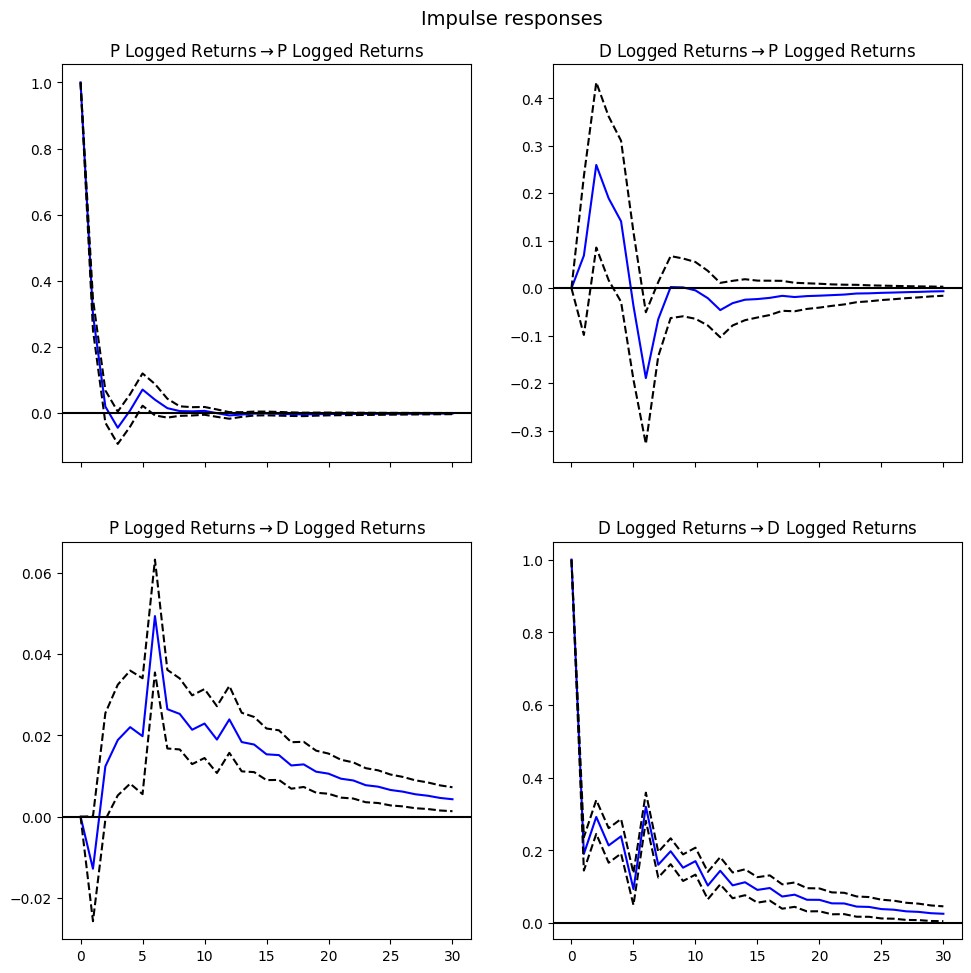

In [154]:
# impulse response plots
VAR_BIC.irf(30).plot()
plt.show()